## Import Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the MNIST
#### It is a digit recognition problem

In [2]:
from sklearn.datasets import fetch_openml as ftopml

In [3]:
mnist = ftopml('mnist_784', as_frame= False)

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [22]:
X = mnist.data          # each row represent a digit
y = mnist.target

In [23]:
print("Features shape: " , X.shape , "\nTarget shape: " , y.shape) # explore the data set

Features shape:  (10000, 784) 
Target shape:  (10000,)


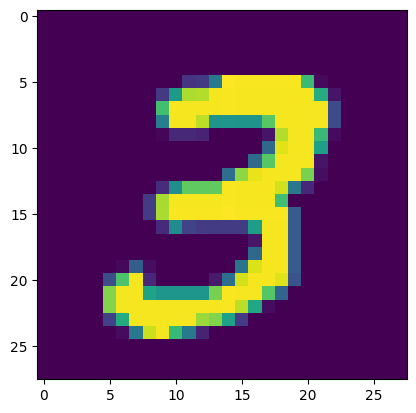

In [24]:
plt.imshow(X[7].reshape(28,28)) # result is 3

In [25]:
from sklearn.model_selection import cross_val_score as cvs, StratifiedKFold as skf, RandomizedSearchCV as rscv, import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as rfc, AdaBoostClassifier as abc
from sklearn.svm import SVC as svc
from sklearn.tree import DecisionTreeClassifier as dtc

In [27]:
kfolds = skf(n_splits= 5, shuffle= True, random_state= 42)

## SVM

In [28]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint as sp_randint

In [29]:
scaler = MinMaxScaler()
scaled_mnist = scaler.fit_transform(X=X)

In [31]:
mySVC = svc(kernel='rbf', random_state= 42)
svcResults = cvs(mySVC, X, y, cv= 5)

## Random Forest

In [34]:
hyper_params = {
    "max_depth": sp_randint(3, 20), 
    "max_features": sp_randint(50, 150), 
    "min_samples_split": sp_randint(20, 120), 
    "bootstrap": [True, False], 
    "criterion": ["gini", "entropy"]
}

In [35]:
rfc_classifier = rfc(random_state = 42)
# perorming randomized search to obtain
# best possible parameters
random_search = rscv(rfc_classifier, param_distributions=hyper_params, 
    n_iter=5, cv=kfolds)  

#### splitting the data

In [37]:
X_train, X_test, y_train, y_test = tts(X,y, train_size= 0.75) 

In [38]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D0CADD0100>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D0E1541DE0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D0E15424A0>})

## AdaBoost Classifier

In [53]:
ada_clf = abc(
    dtc(max_depth = 10, min_samples_split = 10),
    learning_rate = 0.01,
    n_estimators = 100,
    random_state = 42
)

In [54]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    min_samples_split=10),
                   learning_rate=0.01, n_estimators=100, random_state=42)

## Individual Results

In [ ]:
print("Accuracy score SVC:" , svcResults)
# Print the accuracy of the random forest classifier
print("\tAccuracy Table Random Forest:" , "\nFor training: ",
        random_search.score(X_train, y_train), "\nFor testing: ", 
             random_search.score(X_test, y_test))
# Print the accuracy of the ada boost classifier
print("\tAccuracy Table AdaBoost:" , "\nFor training: ",
        ada_clf.score(X_train, y_train), "\nFor testing: ", 
             ada_clf.score(X_test, y_test))

## Let's vote for the best

In [56]:
from sklearn.ensemble import VotingClassifier as vc

In [60]:
voting_clf = vc(
    estimators = [('Random' , random_search),
    ('Ada', ada_clf),
    ('SVC', mySVC)]
    )

In [61]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Random',
                              RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                 estimator=RandomForestClassifier(random_state=42),
                                                 n_iter=5,
                                                 param_distributions={'bootstrap': [True,
                                                                                    False],
                                                                      'criterion': ['gini',
                                                                                    'entropy'],
                                                                      'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D0CADD0100>,
                                                                      'ma..._distn_infrastructure.rv_discrete_frozen object at 0x000002D0E1541DE0>,
                                                                      'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D0E15424A0>})),
                             ('Ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                                                  min_samples_split=10),
                                                 learning_rate=0.01,
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('SVC', SVC(random_state=42))])

In [62]:
print("\tAccuracy Table:" , "\nFor training: ",
        voting_clf.score(X_train, y_train), "\nFor testing: ", 
             voting_clf.score(X_test, y_test))

	Accuracy Table: 
For training:  0.9913333333333333 
For testing:  0.9444


## Final Results

In [63]:
classifiers = ["random forest","Adaboost","Voting classifier"]
results = [random_search.score(X_test, y_test), ada_clf.score(X_test, y_test) ,voting_clf.score(X_test, y_test)]

In [70]:
# as we will see the voting classidier is the best in the test data
for i, j in sorted(zip(results, classifiers), reverse= True):
    print(j, i)

Voting classifier 0.9444
random forest 0.936
Adaboost 0.902
